In [1]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D
from utils import draw_figure,compute_pk, plot_residual
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss, l1_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('highest')
device = torch.device("cuda") if torch.cuda.is_available() else "mps"
print(device)

cuda


In [2]:
seed_everything(7, workers=True)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4


[rank: 0] Seed set to 7


In [10]:
class trainCNN(LightningModule):
    def __init__(
        self,
        model,
        learning_rate: float = 3.0e-4,
        weight_decay: float = 1.0e-2,
        n_sampling_steps: int = 250, 
        fourier_upweight_range=(3, 15), 
        fourier_weight=1e0,
        draw_figure=None,
        plot_residual=None,
        dataset='illustris',
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["draw_figure","plot_residual"])
        
        self.model= model
        self.dataset=dataset
        print("suite:", self.dataset)
        self.draw_figure=draw_figure
        self.plot_residual=plot_residual
        self.fourier_upweight_range = fourier_upweight_range
        self.fourier_weight = fourier_weight
        
        if self.draw_figure is None:
            def draw_figure(args,**kwargs):
                fig=plt.figure(figsize=(5,5))
                return fig
            self.draw_figure=draw_figure

    def forward(self, cdm_map, params) -> Tensor:
        cdm_map = cdm_map
        params = params
        output = self.model(cdm_map, params, inverse_blue_filter=False, high_pass=False) #output kernel should give the invertible Fourier transformation
        if not self.training:
            output = self.model(cdm_map, params, inverse_blue_filter=True, high_pass=False, order=3)
        return output

    def evaluate(self, batch: Tuple, stage: str = None) -> Tensor:

        cdm_map,params,true_map = batch
        cdm_map = cdm_map.to(device)
        params = params.to(device)
        true_map = true_map.to(device)
        mtot_pred = self(cdm_map,params).to(device)
        fourier_loss = self.fourier_loss(mtot_pred, true_map)
        # Log the individual loss components
        self.log("fourier_loss", fourier_loss, on_epoch=True, prog_bar=True)
        loss = l1_loss(mtot_pred, true_map)
        self.log("l1_loss", loss, on_epoch=True, prog_bar=True)
        #if self.current_epoch >= 2:
            #loss += fourier_loss
        return fourier_loss

    def get_current_max_freq(self):
        """Calculate current maximum frequency based on training progress"""
        if self.trainer is None:
            return self.fourier_upweight_range[1]
            
        progress = self.current_epoch / self.trainer.max_epochs
        max_freq = self.fourier_upweight_range[1]
    
        if progress < 0.33:
            return max_freq / 3
        elif progress < 0.66:
            return (max_freq * 2) / 3
        else:
            return max_freq

    def get_current_min_freq(self):
        """Calculate current maximum frequency based on training progress"""
        if self.trainer is None:
            return self.fourier_upweight_range[0]
            
        progress = self.current_epoch / self.trainer.max_epochs
        min_freq = self.fourier_upweight_range[0]
    
        if progress < 0.33:
            return 0.5
        elif progress < 0.66:
            return (min_freq * 2) / 3
        else:
            return min_freq
       
    
    def fourier_loss(self, output, target):

        output_fft = torch.fft.fft2(output)
        target_fft = torch.fft.fft2(target)
    
        _, _, H, W = output.shape
        L = 25. #Mpc/c

        kx = torch.fft.fftfreq(H, d=1. / (H * 2 * np.pi / L)).to(output.device)
        ky = torch.fft.fftfreq(W, d=1. / (W * 2 * np.pi / L)).to(output.device)
        kx, ky = torch.meshgrid(kx, ky, indexing="ij") #[256, 256],[256, 256]
        k = torch.sqrt(kx**2 + ky**2) 


        ## Blue weighted filter FFT−1 (FFT(img)*k^order)
        order = 3
        weight_mask = k**order
        weight_mask[0, 0] = 1.0 
        
        ## Low pass only
        #high = self.get_current_max_freq() #self.fourier_upweight_range[1]
        #low = self.fourier_upweight_range[0] #self.get_current_min_freq() #
        #order = 2 
        #low_pass = 1 / (1 + (k / high)**(2 * order))
        #high_pass = 1 / (1 + (low / k)**(2 * order))
        #weight_mask = self.fourier_weight*low_pass 

        ## Window Functions
        #weight_mask = self.fourier_weight*low_pass*high_pass #change to Butterworth filter
        
        
        #weight_mask = torch.zeros_like(k)
        #weight_mask[(k >= low) & (k <= high)] = self.fourier_weight # Double weight in the range
    
        # Expand the mask for all batches and channels
        weight_mask = weight_mask[None, None, :, :].to(output.device)
        loss = torch.mean( (weight_mask * output_fft - weight_mask * target_fft).real ** 2) + torch.mean((weight_mask * output_fft - weight_mask * target_fft).imag ** 2) #r_cc is phase not mag

        return loss


    def training_step(
        self,
        batch: Tuple,
        batch_idx: int,
    ) -> Tensor:
        loss = self.evaluate(batch, "train")
        self.log("train_loss", loss, on_epoch=True)
        log_loss = torch.log(loss)
        return log_loss


    def validation_step(self, batch: Tuple, batch_idx: int) -> Tensor:
        """validate model

        Args:
            batch (Tuple): batch of examples
            batch_idx (int): idx for batch

        Returns:
            Tensor: loss
        """
        conditioning,params,x = batch 
        loss = self.evaluate(batch)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset,model='UNet')
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset, stage='val')
            
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)
          
            plt.close()
        return loss

    def test_step(self, batch, batch_idx):
        
        conditioning, params, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset,model='UNet')
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset)
            self.log_dict({'test_loss': loss}, on_epoch=True)
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)

                loss = self.evaluate(batch, "test")
                self.logger.log_metrics({"test_loss": loss.mean()})
            plt.show()
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer,
            T_0=10, # ~ num_steps // 3
            eta_min=3e-5,

        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        cdm_map,params,true_map = batch
        return self(cdm_map,params)

In [11]:
import importlib
import unet_parts
import unet_model
import camel_dataloader
import utils

importlib.reload(camel_dataloader) 
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D

importlib.reload(utils) 
importlib.reload(unet_parts) 
from utils import draw_figure

importlib.reload(unet_model) 
from unet_model import UNetFiLM

In [12]:
sys.path.append('/pscratch/sd/l/lindajin/Pytorch-UNet/unet')
from unet_model import UNetFiLM,ResNetFiLM,UNetFiLMNoSkip
cnn = trainCNN(
        model =UNetFiLMNoSkip(1,1), #.to(device) #SimpleNet() #ResnetGenerator(1,1) #SimpleNet()
        dataset=dataset,
        learning_rate=learning_rate,
        image_shape=(1,cropsize,cropsize),
        draw_figure=draw_figure,
        plot_residual=plot_residual
    ).to(device)

    # Checkpoint every time val_loss improves
val_checkpoint = ModelCheckpoint(
        filename="best_model-{epoch}-{step}",
        monitor="val_loss",
         save_top_k=1, # save only the best ckpt
        mode="min",
        verbose=True,        
    )

    # Checkpoint at every 6000 steps
latest_checkpoint = ModelCheckpoint(
        filename="latest-{epoch}-{step}",
        monitor="step",
        mode="max",
        every_n_train_steps=50, # 50 6000
        save_top_k=10
    )

comet_logger = CometLogger(
            api_key=os.environ.get("COMET_API_KEY"),
            project_name="Nbody_Hydro",
            experiment_name='UNet_noSkip_epoch10_filter-boosted_gamma_3_log_Fourier_ONLY_weight_1e0_lr_1e3_adamw_1e2_25_thickness_Nbody',
            offline=False,
            save_dir='/pscratch/sd/l/lindajin/LOGS/'
            #'Unet_TF_fft' too slow
        )

trainer = Trainer(
        logger=comet_logger,
        accelerator="auto",
        max_epochs=10, #10 1000
        gradient_clip_val=0.5,
        callbacks=[LearningRateMonitor(),
                    latest_checkpoint,
                    val_checkpoint]
    )

CometLogger will be initialized in online mode
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


suite: Astrid


In [18]:
print(cnn.device)

cuda:0


In [31]:
import importlib
import unet_model
import utils
importlib.reload(unet_model) 
importlib.reload(utils) 
from utils import power, draw_figure
from unet_model import UNetFiLM, FiLM, ResNetFiLM

## Conditional ResNet: m_cdm -> m_tot (25 thickness)

In [8]:
dm_25_thick_mtot = get_astro_data(
        dataset,
        25,
        num_workers=num_workers,
        batch_size=batch_size,
    )

In [23]:
trainer.fit(model=cnn, datamodule=dm_25_thick_mtot) 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/f1270bef521a4ef9baed95e5a6fbefaa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | ResNetFiLM | 21.9 M | train
---------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.748    Total estimated model params size (MB)
121       Modules in train mode
0         Modules in eval mode
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'ResNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64,

no high passing DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
no high pass

Computing power spectra of the fields...
Time FFTS = 0.79                                                   
Time loop = 0.00
Time taken = 0.81 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS 

/global/homes/l/lindajin/utils.py:97: RuntimeWarning: invalid value encountered in divide
  Pkcc = PKL.XPk_plane(x_, x2_,  BoxSize, MAS, MAS, threads=1)


no high passing DataLoader 0:  50%|█████     | 1/2 [00:07<00:07,  0.14it/s]
no high pass%|          | 0/175 [00:00<?, ?it/s]                           
no high pass%|          | 1/175 [00:00<00:26,  6.45it/s, v_num=efaa, fourier_loss_step=4.380, l1_loss_step=0.908]
no high pass%|          | 2/175 [00:00<00:22,  7.54it/s, v_num=efaa, fourier_loss_step=5.800, l1_loss_step=1.080]
no high pass%|▏         | 3/175 [00:00<00:21,  7.98it/s, v_num=efaa, fourier_loss_step=4.550, l1_loss_step=0.853]
no high pass%|▏         | 4/175 [00:00<00:20,  8.28it/s, v_num=efaa, fourier_loss_step=3.700, l1_loss_step=0.837]
no high pass%|▎         | 5/175 [00:00<00:20,  8.45it/s, v_num=efaa, fourier_loss_step=3.340, l1_loss_step=0.720]
no high pass%|▎         | 6/175 [00:00<00:19,  8.58it/s, v_num=efaa, fourier_loss_step=3.130, l1_loss_step=0.775]
no high pass%|▍         | 7/175 [00:00<00:19,  8.68it/s, v_num=efaa, fourier_loss_step=2.150, l1_loss_step=0.855]
no high pass%|▍         | 8/175 [00:00<00:19,  8.7

Epoch 0, global step 175: 'val_loss' reached 1.39301 (best 1.39301), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=0-step=175.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.610, l1_loss_step=0.548, fourier_loss=1.390, l1_loss=0.524, val_loss=1.390, fourier_loss_epoch=1.650, l1_loss_epoch=0.573]          
no high pass%|          | 1/175 [00:00<01:44,  1.67it/s, v_num=efaa, fourier_loss_step=1.870, l1_loss_step=0.521, fourier_loss=1.390, l1_loss=0.524, val_loss=1.390, fourier_loss_epoch=1.650, l1_loss_epoch=0.573]
no high pass%|          | 2/175 [00:00<01:01,  2.83it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.550, fourier_loss=1.390, l1_loss=0.524, val_loss=1.390, fourier_loss_epoch=1.650, l1_loss_epoch=0.573]
no high pass%|▏         | 3/175 [00:00<00:46,  3.69it/s, v_num=efaa, fourier_loss_step=1.560, l1_loss_step=0.516, fourier_loss=1.390, l1_loss=0.524, val_loss=1.390, fourier_loss_epoch=1.650, l1_loss_epoch=0.573]
no high pass%|▏         | 4/175 [00:00<00:39,  4.34it/s, v_num=efaa, fourier_loss_step=1.210, l1_loss_step=0.562, fourier_loss=1.390, l1_loss=0.524, v

Epoch 1, global step 350: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.460, l1_loss_step=0.520, fourier_loss=1.400, l1_loss=0.544, val_loss=1.400, fourier_loss_epoch=1.420, l1_loss_epoch=0.541]          
no high pass%|          | 1/175 [00:00<01:13,  2.38it/s, v_num=efaa, fourier_loss_step=1.100, l1_loss_step=0.527, fourier_loss=1.400, l1_loss=0.544, val_loss=1.400, fourier_loss_epoch=1.420, l1_loss_epoch=0.541]
no high pass%|          | 2/175 [00:00<00:45,  3.79it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.504, fourier_loss=1.400, l1_loss=0.544, val_loss=1.400, fourier_loss_epoch=1.420, l1_loss_epoch=0.541]
no high pass%|▏         | 3/175 [00:00<00:36,  4.71it/s, v_num=efaa, fourier_loss_step=1.180, l1_loss_step=0.517, fourier_loss=1.400, l1_loss=0.544, val_loss=1.400, fourier_loss_epoch=1.420, l1_loss_epoch=0.541]
no high pass%|▏         | 4/175 [00:00<00:31,  5.37it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.543, fourier_loss=1.400, l1_loss=0.544, v

Epoch 2, global step 525: 'val_loss' reached 1.31727 (best 1.31727), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=2-step=525.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.150, l1_loss_step=0.608, fourier_loss=1.320, l1_loss=0.516, val_loss=1.320, fourier_loss_epoch=1.400, l1_loss_epoch=0.541]          
no high pass%|          | 1/175 [00:00<02:07,  1.37it/s, v_num=efaa, fourier_loss_step=1.080, l1_loss_step=0.542, fourier_loss=1.320, l1_loss=0.516, val_loss=1.320, fourier_loss_epoch=1.400, l1_loss_epoch=0.541]
no high pass%|          | 2/175 [00:00<01:12,  2.37it/s, v_num=efaa, fourier_loss_step=1.230, l1_loss_step=0.538, fourier_loss=1.320, l1_loss=0.516, val_loss=1.320, fourier_loss_epoch=1.400, l1_loss_epoch=0.541]
no high pass%|▏         | 3/175 [00:00<00:54,  3.16it/s, v_num=efaa, fourier_loss_step=1.460, l1_loss_step=0.563, fourier_loss=1.320, l1_loss=0.516, val_loss=1.320, fourier_loss_epoch=1.400, l1_loss_epoch=0.541]
no high pass%|▏         | 4/175 [00:01<00:45,  3.78it/s, v_num=efaa, fourier_loss_step=1.230, l1_loss_step=0.504, fourier_loss=1.320, l1_loss=0.516, v

Epoch 3, global step 700: 'val_loss' reached 1.30940 (best 1.30940), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=3-step=700.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.558, fourier_loss=1.310, l1_loss=0.536, val_loss=1.310, fourier_loss_epoch=1.390, l1_loss_epoch=0.540]          
no high pass%|          | 1/175 [00:00<01:16,  2.27it/s, v_num=efaa, fourier_loss_step=1.310, l1_loss_step=0.559, fourier_loss=1.310, l1_loss=0.536, val_loss=1.310, fourier_loss_epoch=1.390, l1_loss_epoch=0.540]
no high pass%|          | 2/175 [00:00<00:47,  3.65it/s, v_num=efaa, fourier_loss_step=1.110, l1_loss_step=0.585, fourier_loss=1.310, l1_loss=0.536, val_loss=1.310, fourier_loss_epoch=1.390, l1_loss_epoch=0.540]
no high pass%|▏         | 3/175 [00:00<00:37,  4.57it/s, v_num=efaa, fourier_loss_step=1.290, l1_loss_step=0.555, fourier_loss=1.310, l1_loss=0.536, val_loss=1.310, fourier_loss_epoch=1.390, l1_loss_epoch=0.540]
no high pass%|▏         | 4/175 [00:00<00:32,  5.23it/s, v_num=efaa, fourier_loss_step=1.040, l1_loss_step=0.547, fourier_loss=1.310, l1_loss=0.536, v

Epoch 4, global step 875: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.350, l1_loss_step=0.501, fourier_loss=1.410, l1_loss=0.527, val_loss=1.410, fourier_loss_epoch=1.350, l1_loss_epoch=0.535]          
no high pass%|          | 1/175 [00:00<01:28,  1.96it/s, v_num=efaa, fourier_loss_step=1.620, l1_loss_step=0.541, fourier_loss=1.410, l1_loss=0.527, val_loss=1.410, fourier_loss_epoch=1.350, l1_loss_epoch=0.535]
no high pass%|          | 2/175 [00:00<00:53,  3.23it/s, v_num=efaa, fourier_loss_step=2.000, l1_loss_step=0.552, fourier_loss=1.410, l1_loss=0.527, val_loss=1.410, fourier_loss_epoch=1.350, l1_loss_epoch=0.535]
no high pass%|▏         | 3/175 [00:00<00:41,  4.11it/s, v_num=efaa, fourier_loss_step=0.970, l1_loss_step=0.502, fourier_loss=1.410, l1_loss=0.527, val_loss=1.410, fourier_loss_epoch=1.350, l1_loss_epoch=0.535]
no high pass%|▏         | 4/175 [00:00<00:35,  4.77it/s, v_num=efaa, fourier_loss_step=1.140, l1_loss_step=0.513, fourier_loss=1.410, l1_loss=0.527, v

Epoch 5, global step 1050: 'val_loss' reached 1.29843 (best 1.29843), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=5-step=1050.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.150, l1_loss_step=0.502, fourier_loss=1.300, l1_loss=0.518, val_loss=1.300, fourier_loss_epoch=1.340, l1_loss_epoch=0.532]          
no high pass%|          | 1/175 [00:00<01:17,  2.25it/s, v_num=efaa, fourier_loss_step=1.200, l1_loss_step=0.495, fourier_loss=1.300, l1_loss=0.518, val_loss=1.300, fourier_loss_epoch=1.340, l1_loss_epoch=0.532]
no high pass%|          | 2/175 [00:00<00:48,  3.58it/s, v_num=efaa, fourier_loss_step=1.720, l1_loss_step=0.512, fourier_loss=1.300, l1_loss=0.518, val_loss=1.300, fourier_loss_epoch=1.340, l1_loss_epoch=0.532]
no high pass%|▏         | 3/175 [00:00<00:38,  4.50it/s, v_num=efaa, fourier_loss_step=1.300, l1_loss_step=0.567, fourier_loss=1.300, l1_loss=0.518, val_loss=1.300, fourier_loss_epoch=1.340, l1_loss_epoch=0.532]
no high pass%|▏         | 4/175 [00:00<00:33,  5.16it/s, v_num=efaa, fourier_loss_step=1.180, l1_loss_step=0.553, fourier_loss=1.300, l1_loss=0.518, v

Epoch 6, global step 1225: 'val_loss' reached 1.26965 (best 1.26965), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=6-step=1225.ckpt' as top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.110, l1_loss_step=0.523, fourier_loss=1.270, l1_loss=0.534, val_loss=1.270, fourier_loss_epoch=1.330, l1_loss_epoch=0.528]          
no high pass%|          | 1/175 [00:00<01:13,  2.37it/s, v_num=efaa, fourier_loss_step=1.520, l1_loss_step=0.529, fourier_loss=1.270, l1_loss=0.534, val_loss=1.270, fourier_loss_epoch=1.330, l1_loss_epoch=0.528]
no high pass%|          | 2/175 [00:00<00:46,  3.71it/s, v_num=efaa, fourier_loss_step=1.510, l1_loss_step=0.527, fourier_loss=1.270, l1_loss=0.534, val_loss=1.270, fourier_loss_epoch=1.330, l1_loss_epoch=0.528]
no high pass%|▏         | 3/175 [00:00<00:37,  4.64it/s, v_num=efaa, fourier_loss_step=1.210, l1_loss_step=0.524, fourier_loss=1.270, l1_loss=0.534, val_loss=1.270, fourier_loss_epoch=1.330, l1_loss_epoch=0.528]
no high pass%|▏         | 4/175 [00:00<00:32,  5.29it/s, v_num=efaa, fourier_loss_step=1.260, l1_loss_step=0.554, fourier_loss=1.270, l1_loss=0.534, v

Epoch 7, global step 1400: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.110, l1_loss_step=0.516, fourier_loss=1.300, l1_loss=0.549, val_loss=1.300, fourier_loss_epoch=1.320, l1_loss_epoch=0.531]          
no high pass%|          | 1/175 [00:00<01:10,  2.45it/s, v_num=efaa, fourier_loss_step=1.500, l1_loss_step=0.521, fourier_loss=1.300, l1_loss=0.549, val_loss=1.300, fourier_loss_epoch=1.320, l1_loss_epoch=0.531]
no high pass%|          | 2/175 [00:00<00:44,  3.88it/s, v_num=efaa, fourier_loss_step=1.170, l1_loss_step=0.529, fourier_loss=1.300, l1_loss=0.549, val_loss=1.300, fourier_loss_epoch=1.320, l1_loss_epoch=0.531]
no high pass%|▏         | 3/175 [00:00<00:35,  4.79it/s, v_num=efaa, fourier_loss_step=1.210, l1_loss_step=0.516, fourier_loss=1.300, l1_loss=0.549, val_loss=1.300, fourier_loss_epoch=1.320, l1_loss_epoch=0.531]
no high pass%|▏         | 4/175 [00:00<00:31,  5.45it/s, v_num=efaa, fourier_loss_step=1.450, l1_loss_step=0.542, fourier_loss=1.300, l1_loss=0.549, v

Epoch 8, global step 1575: 'val_loss' was not in top 1


no high pass%|          | 0/175 [00:00<?, ?it/s, v_num=efaa, fourier_loss_step=1.380, l1_loss_step=0.519, fourier_loss=1.280, l1_loss=0.512, val_loss=1.280, fourier_loss_epoch=1.320, l1_loss_epoch=0.527]          
no high pass%|          | 1/175 [00:00<01:12,  2.39it/s, v_num=efaa, fourier_loss_step=1.020, l1_loss_step=0.545, fourier_loss=1.280, l1_loss=0.512, val_loss=1.280, fourier_loss_epoch=1.320, l1_loss_epoch=0.527]
no high pass%|          | 2/175 [00:00<00:45,  3.80it/s, v_num=efaa, fourier_loss_step=1.340, l1_loss_step=0.523, fourier_loss=1.280, l1_loss=0.512, val_loss=1.280, fourier_loss_epoch=1.320, l1_loss_epoch=0.527]
no high pass%|▏         | 3/175 [00:00<00:36,  4.72it/s, v_num=efaa, fourier_loss_step=1.350, l1_loss_step=0.511, fourier_loss=1.280, l1_loss=0.512, val_loss=1.280, fourier_loss_epoch=1.320, l1_loss_epoch=0.527]
no high pass%|▏         | 4/175 [00:00<00:31,  5.37it/s, v_num=efaa, fourier_loss_step=1.060, l1_loss_step=0.539, fourier_loss=1.280, l1_loss=0.512, v

Epoch 9, global step 1750: 'val_loss' reached 1.26763 (best 1.26763), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/best_model-epoch=9-step=1750.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 175/175 [00:29<00:00,  5.89it/s, v_num=efaa, fourier_loss_step=1.150, l1_loss_step=0.511, fourier_loss=1.270, l1_loss=0.517, val_loss=1.270, fourier_loss_epoch=1.310, l1_loss_epoch=0.527]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_TF_Film_epoch10_Fourier_ONLY_weight_1e5_3_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/f1270bef521a4ef9baed95e5a6fbefaa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss [10]       : (1.2676254510879517, 1.4065982103347778)
COMET INFO:     fourier_loss_epoch [10] : (1.3072618246078491, 1.6497869491577148)
COMET INFO:     fourier_loss_step [35]  : (1.105151653289795, 2.1514666080474854)
COMET INFO:     l1_loss [10]            : (0.5122437477111816, 0.5486211180686951)
COMET INFO:     l1_loss_epoch [10]      : (0.5267202854156494, 0.57277

In [24]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/latest-epoch=9-step=1750.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/f1270bef521a4ef9baed95e5a6fbefaa

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/f1270bef521a4ef9baed95e5a6fbefaa/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'ResNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

no high passLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spect

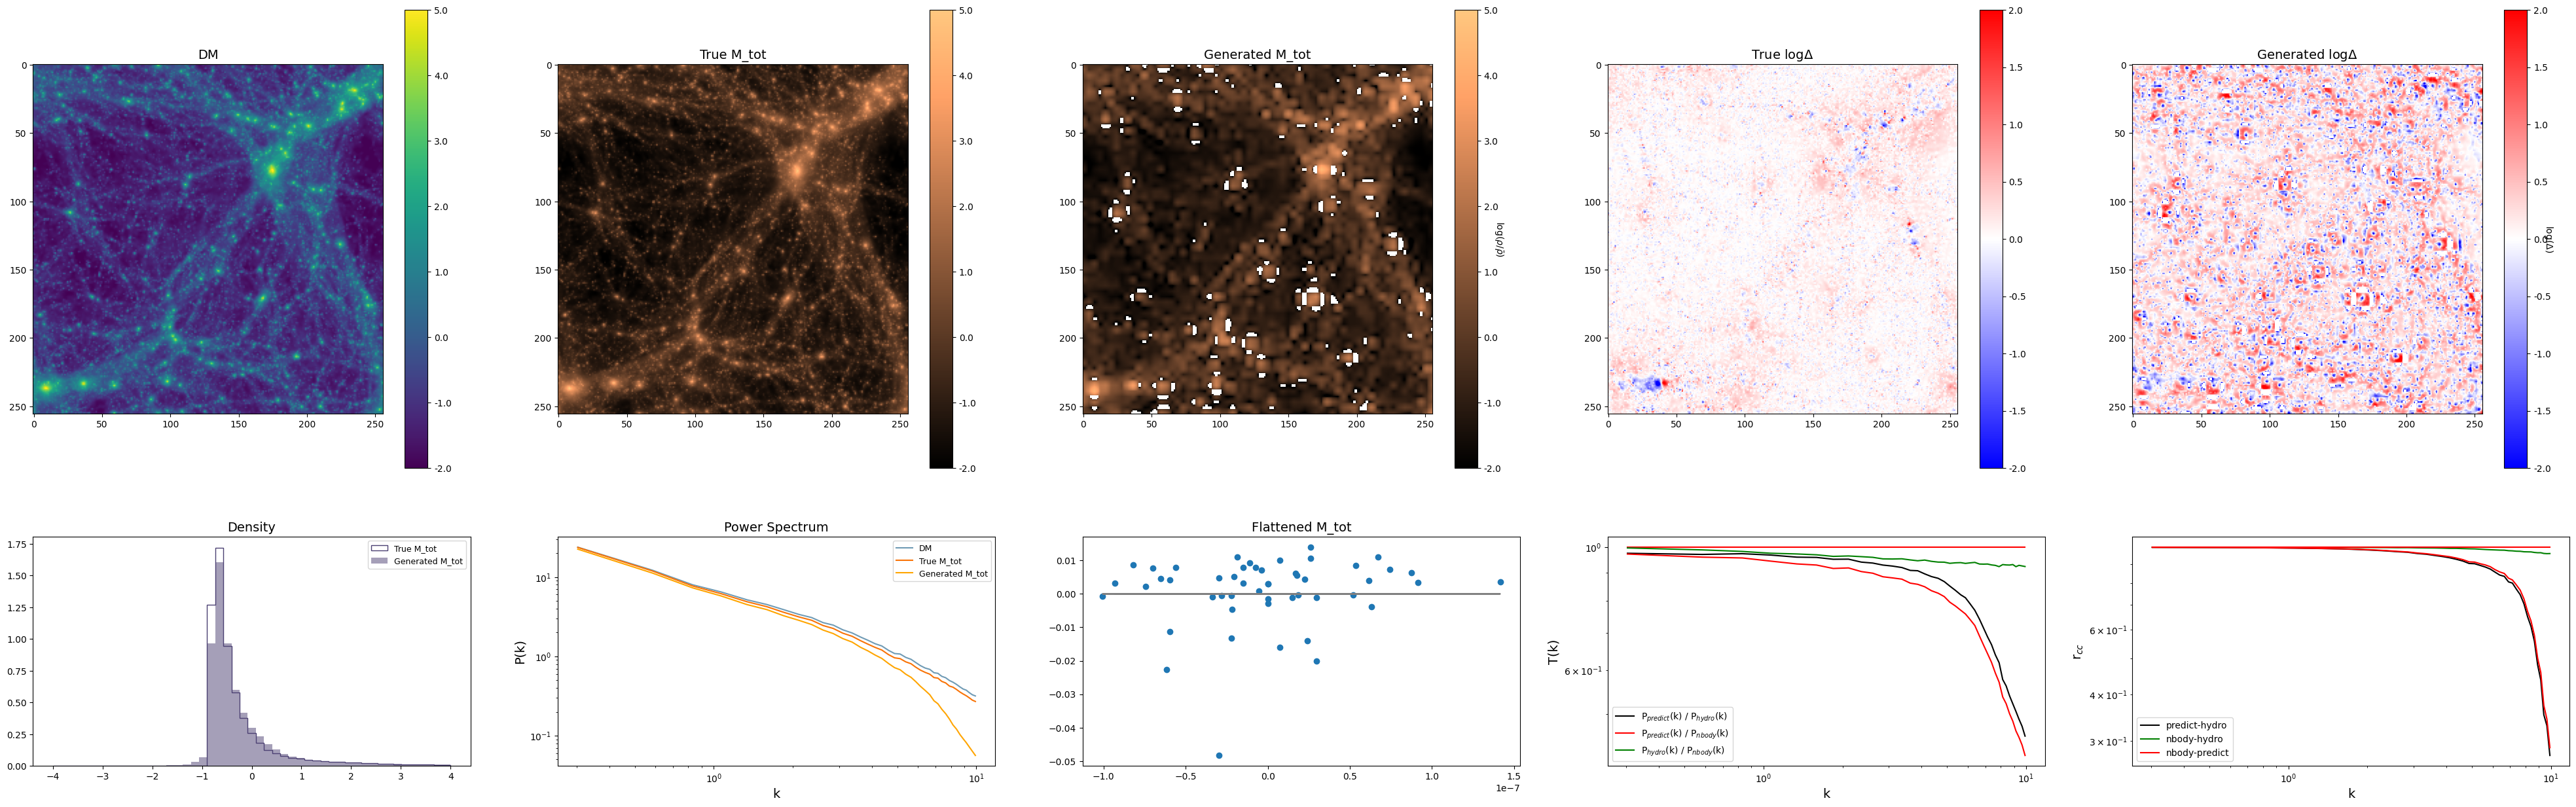

no high pass
Testing DataLoader 0: 100%|██████████| 6/6 [00:11<00:00,  0.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       fourier_loss        │    1.2947319746017456     │
│          l1_loss          │    0.5209683179855347     │
│         test_loss         │            0.0            │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_TF_Film_epoch10_Fourier_ONLY_weight_1e5_3_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/f1270bef521a4ef9baed95e5a6fbefaa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss  : 1.2947319746017456
COMET INFO:     l1_loss       : 0.5209683179855347
COMET INFO:     test_loss [2] : (0.0, 1.2278355360031128)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : ResNet_TF_Film_epoch10_Fourier_ONLY_weight_1e5_3_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:   Parameters:
COMET

In [25]:
test_loss = trainer.test(model=None, datamodule=dm_25_thick_mtot, ckpt_path = path)

In [16]:
comet_logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/23e8b24c00fa47d783b8ee7e9e1d4edd

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_TF_Film_epoch20_Moving_highk_log(Fourier)_ONLY_weight_1e5_10_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/23e8b24c00fa47d783b8ee7e9e1d4edd
COMET INFO:   Others

## Conditional CNN + Fourier Loss: m_cdm -> m_tot-m_cdm(Nbody) (3D->2D: 25 thickness)

In [3]:
dm_25_thick = get_astro_data(
        dataset,
        25,
        num_workers=num_workers,
        batch_size=batch_size,
    )

In [10]:
print(len(dm_25_thick.train_data), len(dm_25_thick.valid_data),len(dm_25_thick.test_data))

2100 600 300


In [13]:
trainer.fit(model=cnn, datamodule=dm_25_thick) 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/b910cc1345984df5a4815c68e7c7a09c

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | UNetFiLMNoSkip | 41.1 M | train
-------------------------------------------------
41.1 M    Trainable params
0         Non-trainable params
41.1 M    Total params
164.340   Total estimated model params size (MB)
104       Modules in train mode
0         Modules in eval mode
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLMNoSkip(
  (inc): DoubleConv(
    (double_conv): Sequential(
    

no high pass, no blue filter in training     | 0/2 [00:00<?, ?it/s]
no high pass, no blue filter in training


/global/homes/l/lindajin/utils.py:216: RuntimeWarning: invalid value encountered in log
  im = ax.flat[2].imshow(np.log(sample0+1), cmap='copper', vmin=-2, vmax=5)



Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time t

Epoch 0, global step 175: 'val_loss' reached 48147960.00000 (best 48147960.00000), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/b910cc1345984df5a4815c68e7c7a09c/checkpoints/best_model-epoch=0-step=175.ckpt' as top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=3.42e+7, l1_loss_step=0.166, fourier_loss=4.81e+7, l1_loss=0.201, val_loss=4.81e+7, fourier_loss_epoch=6.35e+7, l1_loss_epoch=0.256]          
no high pass, no blue filter in training1:02,  2.78it/s, v_num=a09c, fourier_loss_step=4.35e+7, l1_loss_step=0.182, fourier_loss=4.81e+7, l1_loss=0.201, val_loss=4.81e+7, fourier_loss_epoch=6.35e+7, l1_loss_epoch=0.256]
no high pass, no blue filter in training0:41,  4.17it/s, v_num=a09c, fourier_loss_step=4.37e+7, l1_loss_step=0.181, fourier_loss=4.81e+7, l1_loss=0.201, val_loss=4.81e+7, fourier_loss_epoch=6.35e+7, l1_loss_epoch=0.256]
no high pass, no blue filter in training0:33,  5.10it/s, v_num=a09c, fourier_loss_step=4.43e+7, l1_loss_step=0.186, fourier_loss=4.81e+7, l1_loss=0.201, val_loss=4.81e+7, fourier_loss_epoch=6.35e+7, l1_loss_epoch=0.256]
no high pass, no blue filter in training0:29,  5.75it/s, v_num=a09c, fourier_loss_step=4.93e+7, l1_loss_step=0.185, fo

Epoch 1, global step 350: 'val_loss' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=5.02e+7, l1_loss_step=0.202, fourier_loss=4.81e+7, l1_loss=0.232, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]          
no high pass, no blue filter in training1:03,  2.75it/s, v_num=a09c, fourier_loss_step=7.91e+7, l1_loss_step=0.260, fourier_loss=4.81e+7, l1_loss=0.232, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:40,  4.24it/s, v_num=a09c, fourier_loss_step=3.15e+7, l1_loss_step=0.158, fourier_loss=4.81e+7, l1_loss=0.232, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:33,  5.17it/s, v_num=a09c, fourier_loss_step=5.53e+7, l1_loss_step=0.190, fourier_loss=4.81e+7, l1_loss=0.232, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:29,  5.81it/s, v_num=a09c, fourier_loss_step=4.49e+7, l1_loss_step=0.194, fo

Epoch 2, global step 525: 'val_loss' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=4.76e+7, l1_loss_step=0.179, fourier_loss=4.81e+7, l1_loss=0.215, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]          
no high pass, no blue filter in training1:07,  2.59it/s, v_num=a09c, fourier_loss_step=4.54e+7, l1_loss_step=0.179, fourier_loss=4.81e+7, l1_loss=0.215, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:42,  4.02it/s, v_num=a09c, fourier_loss_step=4.32e+7, l1_loss_step=0.183, fourier_loss=4.81e+7, l1_loss=0.215, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:34,  4.95it/s, v_num=a09c, fourier_loss_step=6.25e+7, l1_loss_step=0.204, fourier_loss=4.81e+7, l1_loss=0.215, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:30,  5.60it/s, v_num=a09c, fourier_loss_step=4.56e+7, l1_loss_step=0.196, fo

Epoch 3, global step 700: 'val_loss' reached 48147928.00000 (best 48147928.00000), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/b910cc1345984df5a4815c68e7c7a09c/checkpoints/best_model-epoch=3-step=700.ckpt' as top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=4.31e+7, l1_loss_step=0.181, fourier_loss=4.81e+7, l1_loss=0.201, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]          
no high pass, no blue filter in training1:06,  2.63it/s, v_num=a09c, fourier_loss_step=3.21e+7, l1_loss_step=0.163, fourier_loss=4.81e+7, l1_loss=0.201, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:42,  4.10it/s, v_num=a09c, fourier_loss_step=2.7e+7, l1_loss_step=0.165, fourier_loss=4.81e+7, l1_loss=0.201, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195] 
no high pass, no blue filter in training0:34,  5.02it/s, v_num=a09c, fourier_loss_step=8.34e+7, l1_loss_step=0.252, fourier_loss=4.81e+7, l1_loss=0.201, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:30,  5.64it/s, v_num=a09c, fourier_loss_step=5.06e+7, l1_loss_step=0.190, fo

Epoch 4, global step 875: 'val_loss' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=5.85e+7, l1_loss_step=0.211, fourier_loss=4.81e+7, l1_loss=0.216, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]          
no high pass, no blue filter in training1:06,  2.63it/s, v_num=a09c, fourier_loss_step=5.08e+7, l1_loss_step=0.194, fourier_loss=4.81e+7, l1_loss=0.216, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:42,  4.09it/s, v_num=a09c, fourier_loss_step=3.64e+7, l1_loss_step=0.182, fourier_loss=4.81e+7, l1_loss=0.216, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:34,  5.00it/s, v_num=a09c, fourier_loss_step=5.16e+7, l1_loss_step=0.198, fourier_loss=4.81e+7, l1_loss=0.216, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:30,  5.65it/s, v_num=a09c, fourier_loss_step=4.13e+7, l1_loss_step=0.172, fo

Epoch 5, global step 1050: 'val_loss' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=4.78e+7, l1_loss_step=0.173, fourier_loss=4.81e+7, l1_loss=0.211, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]          
no high pass, no blue filter in training1:09,  2.50it/s, v_num=a09c, fourier_loss_step=4.57e+7, l1_loss_step=0.186, fourier_loss=4.81e+7, l1_loss=0.211, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:44,  3.93it/s, v_num=a09c, fourier_loss_step=6.78e+7, l1_loss_step=0.218, fourier_loss=4.81e+7, l1_loss=0.211, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:35,  4.86it/s, v_num=a09c, fourier_loss_step=4.6e+7, l1_loss_step=0.199, fourier_loss=4.81e+7, l1_loss=0.211, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195] 
no high pass, no blue filter in training0:31,  5.51it/s, v_num=a09c, fourier_loss_step=5.24e+7, l1_loss_step=0.192, fo

Epoch 6, global step 1225: 'val_loss' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=5.56e+7, l1_loss_step=0.231, fourier_loss=4.81e+7, l1_loss=0.203, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]          
no high pass, no blue filter in training1:09,  2.50it/s, v_num=a09c, fourier_loss_step=4.24e+7, l1_loss_step=0.192, fourier_loss=4.81e+7, l1_loss=0.203, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:44,  3.92it/s, v_num=a09c, fourier_loss_step=5.51e+7, l1_loss_step=0.194, fourier_loss=4.81e+7, l1_loss=0.203, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:35,  4.85it/s, v_num=a09c, fourier_loss_step=7.35e+7, l1_loss_step=0.232, fourier_loss=4.81e+7, l1_loss=0.203, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:31,  5.50it/s, v_num=a09c, fourier_loss_step=6.68e+7, l1_loss_step=0.224, fo

Epoch 7, global step 1400: 'val_loss' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=5.11e+7, l1_loss_step=0.190, fourier_loss=4.81e+7, l1_loss=0.206, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]          
no high pass, no blue filter in training1:10,  2.47it/s, v_num=a09c, fourier_loss_step=4.5e+7, l1_loss_step=0.176, fourier_loss=4.81e+7, l1_loss=0.206, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195] 
no high pass, no blue filter in training0:44,  3.90it/s, v_num=a09c, fourier_loss_step=6.37e+7, l1_loss_step=0.201, fourier_loss=4.81e+7, l1_loss=0.206, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:35,  4.84it/s, v_num=a09c, fourier_loss_step=4.34e+7, l1_loss_step=0.190, fourier_loss=4.81e+7, l1_loss=0.206, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:31,  5.49it/s, v_num=a09c, fourier_loss_step=5.15e+7, l1_loss_step=0.197, fo

Epoch 8, global step 1575: 'val_loss' was not in top 1


no high pass, no blue filter in training, ?it/s, v_num=a09c, fourier_loss_step=3.97e+7, l1_loss_step=0.188, fourier_loss=4.81e+7, l1_loss=0.207, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]          
no high pass, no blue filter in training1:15,  2.32it/s, v_num=a09c, fourier_loss_step=6.17e+7, l1_loss_step=0.198, fourier_loss=4.81e+7, l1_loss=0.207, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:47,  3.68it/s, v_num=a09c, fourier_loss_step=2.91e+7, l1_loss_step=0.166, fourier_loss=4.81e+7, l1_loss=0.207, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:37,  4.56it/s, v_num=a09c, fourier_loss_step=6.18e+7, l1_loss_step=0.212, fourier_loss=4.81e+7, l1_loss=0.207, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]
no high pass, no blue filter in training0:32,  5.21it/s, v_num=a09c, fourier_loss_step=3.8e+7, l1_loss_step=0.185, fou

Epoch 9, global step 1750: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 175/175 [00:31<00:00,  5.64it/s, v_num=a09c, fourier_loss_step=3.65e+7, l1_loss_step=0.179, fourier_loss=4.81e+7, l1_loss=0.207, val_loss=4.81e+7, fourier_loss_epoch=5.07e+7, l1_loss_epoch=0.195]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet_noSkip_epoch10_filter-boosted_gamma_1_log_Fourier_ONLY_weight_1e0_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/b910cc1345984df5a4815c68e7c7a09c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss [10]       : (48147928.0, 48148224.0)
COMET INFO:     fourier_loss_epoch [10] : (50711068.0, 63497428.0)
COMET INFO:     fourier_loss_step [35]  : (34845544.0, 65956712.0)
COMET INFO:     l1_loss [10]            : (0.20102816820144653, 0.2318354845046997)
COMET INFO:     l1_loss_epoch [10]      : (0.19462859630584717, 0.2558010220527649)
COMET INFO:     l1_loss_s

In [14]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/b910cc1345984df5a4815c68e7c7a09c/checkpoints/latest-epoch=9-step=1750.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/b910cc1345984df5a4815c68e7c7a09c

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/b910cc1345984df5a4815c68e7c7a09c/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLMNoSkip(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

no high pass, no blue filter in training/6 [00:00<?, ?it/s]

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spect

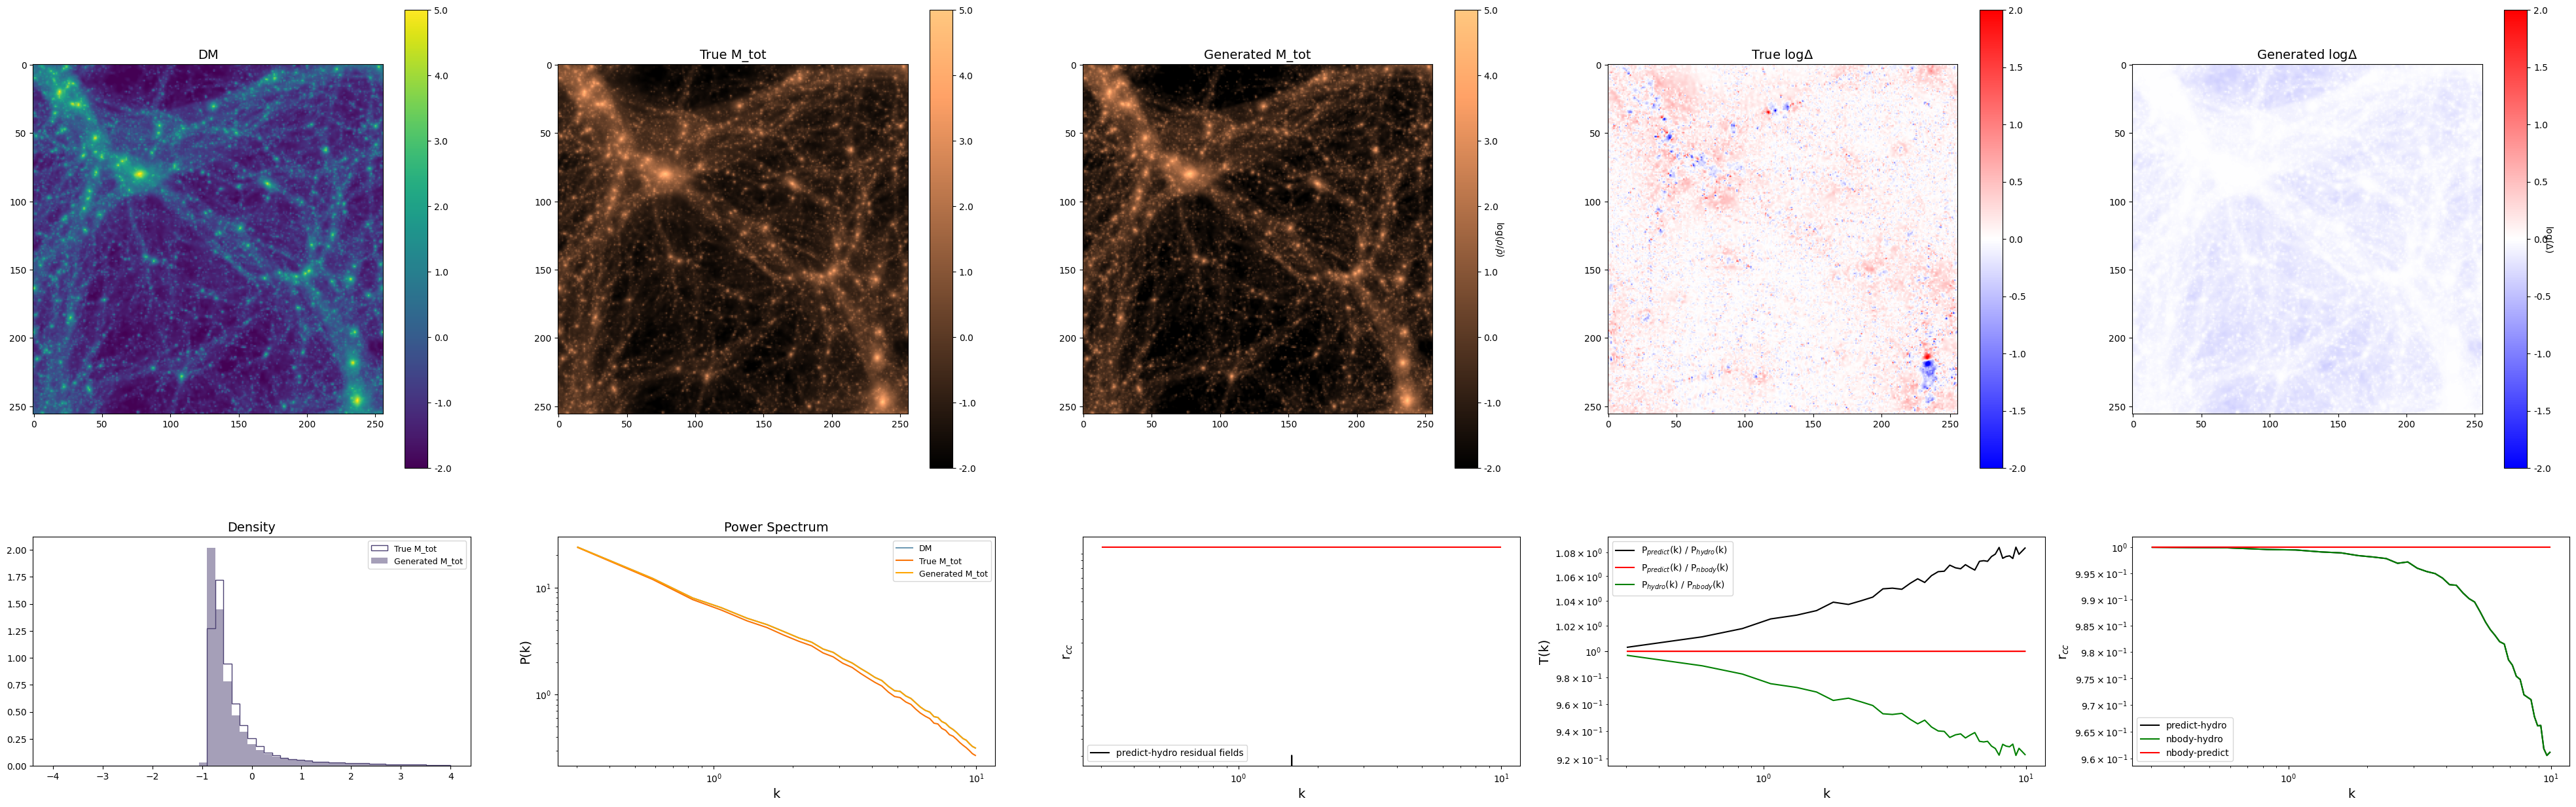

no high pass, no blue filter in training
no high pass, no blue filter in training/6 [00:12<01:01,  0.08it/s]
no high pass, no blue filter in training/6 [00:12<00:24,  0.16it/s]
no high pass, no blue filter in training/6 [00:12<00:12,  0.24it/s]
no high pass, no blue filter in training/6 [00:12<00:06,  0.31it/s]
no high pass, no blue filter in training/6 [00:12<00:02,  0.39it/s]
Testing DataLoader 0: 100%|██████████| 6/6 [00:13<00:00,  0.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       fourier_loss        │        49470640.0         │
│          l1_loss          │    0.20516355335712433    │
│         test_loss         │            0.0            │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet_noSkip_epoch10_filter-boosted_gamma_1_log_Fourier_ONLY_weight_1e0_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/b910cc1345984df5a4815c68e7c7a09c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss  : 49470640.0
COMET INFO:     l1_loss       : 0.20516355335712433
COMET INFO:     test_loss [2] : (0.0, 44920592.0)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : UNet_noSkip_epoch10_filter-boosted_gamma_1_log_Fourier_ONLY_weight_1e0_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:   Parameters:
COMET 

In [15]:
#model = None: directly load from ckpt
test_loss = trainer.test(model=None, datamodule=dm_25_thick, ckpt_path = path)

In [16]:
comet_logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/b910cc1345984df5a4815c68e7c7a09c

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet_noSkip_epoch10_filter-boosted_gamma_1_log_Fourier_ONLY_weight_1e0_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/b910cc1345984df5a4815c68e7c7a09c
COMET INFO:   Others:
COMET I

## Conditional CNN + Fourier Loss + TF: m_cdm -> m_tot-m_cdm_tf (3D->2D: 25 thickness)

In [8]:
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size)

In [11]:
print(len(dm_TF.train_data), len(dm_TF.valid_data),len(dm_TF.test_data)) #sum to 3000

2400 420 180


In [ ]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

In [8]:
path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_25_thick = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/5ef90d60aaca4012837cd4275273e171/checkpoints/latest-epoch=9-step=1750.ckpt'
path_UNet_Film_10_epochs_ONLY_l1_loss_25_thick = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/62ce892d8ce84414ad1d864f0b3c09a3/checkpoints/latest-epoch=9-step=1750.ckpt'

## test if CNN_apply is correct --> ✅

In [ ]:
comet_logger.experiment.end()

In [70]:
test_predictions_ONLY_fourier_loss = trainer.predict(model=cnn, dataloaders=dm_25_thick.train_dataloader(), ckpt_path = path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_25_thick)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/5ef90d60aaca4012837cd4275273e171/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Predicting DataLoader 0: 100%|██████████| 175/175 [00:05<00:00, 29.50it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.005
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel

In [72]:
test_predictions_ONLY_fourier_loss = np.array(test_predictions_ONLY_fourier_loss).reshape([2100,256,256]) #path_UNet_Film_50_epochs_fourier_loss_2_10

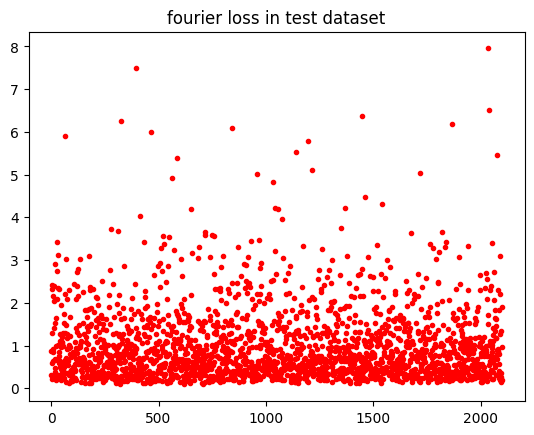

In [86]:
test_target = []
for t in dm_25_thick.train_data:
    test_target.append(t[2])
    
test_predictions_ONLY_fourier_loss_ = Tensor(np.array(test_predictions_ONLY_fourier_loss)).unsqueeze(1)
test_predictions_ = Tensor(test_predictions).unsqueeze(1)

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss = cnn.fourier_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    plt.plot(i, loss, '.', c='r')
plt.title('fourier loss in test dataset')
plt.show()

In [84]:
print(len(test_target))

2100


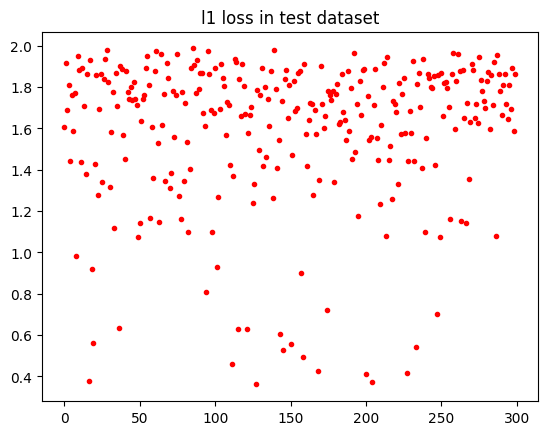

In [44]:
plt.figure()
for i in np.arange(len(test_predictions)):                
    loss =  l1_loss(test_predictions_[i].unsqueeze(0), test_targets_[i])
    plt.plot(i, loss, '.', c='r')
plt.title('l1 loss in test dataset')
plt.show()

In [75]:
test_predictions = trainer.predict(model=cnn, dataloaders=dm_25_thick.train_dataloader(), ckpt_path = path_UNet_Film_10_epochs_ONLY_l1_loss_25_thick)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/62ce892d8ce84414ad1d864f0b3c09a3/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Predicting DataLoader 0: 100%|██████████| 175/175 [00:05<00:00, 29.36it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.005
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel

train on L1 only


/tmp/ipykernel_1997182/3169583532.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_predictions = Tensor(np.array(test_predictions).reshape([2100,1,256,256]))


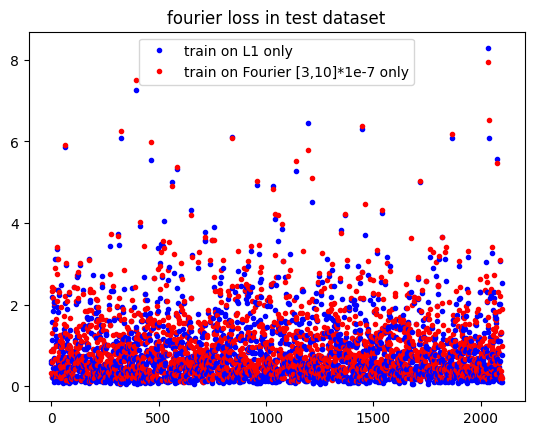

/tmp/ipykernel_1997182/3169583532.py:23: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss =  l1_loss(test_predictions[i].unsqueeze(0), test_target[i])
/tmp/ipykernel_1997182/3169583532.py:28: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = l1_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])


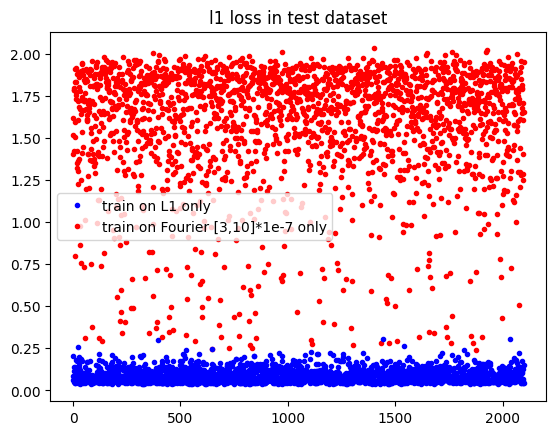

In [87]:
print('train on L1 only')

test_predictions = Tensor(np.array(test_predictions).reshape([2100,1,256,256]))

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss = cnn.fourier_loss(test_predictions[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='b', label = 'train on L1 only')
    else:
        plt.plot(i, loss, '.', c='b')
    loss = cnn.fourier_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='r', label = 'train on Fourier [3,10]*1e-7 only')
    else:
        plt.plot(i, loss, '.', c='r')
plt.title('fourier loss in test dataset')
plt.legend()
plt.show()

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss =  l1_loss(test_predictions[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='b', label = 'train on L1 only')
    else:
        plt.plot(i, loss, '.', c='b')
    loss = l1_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='r', label = 'train on Fourier [3,10]*1e-7 only')
    else:
        plt.plot(i, loss, '.', c='r')
plt.title('l1 loss in test dataset')
plt.legend()
plt.show()